### 1. Import the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# We set up Matplotlib to display plots directly in the notebook:
%matplotlib inline

import seaborn as sns

In [2]:
heart = pd.read_csv('./heart_2.csv')

In [3]:
heart.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
df = heart

### 2. Explore the data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [6]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [7]:
from ydata_profiling import ProfileReport

In [8]:
#ProfileReport(df, minimal=True)

In [9]:
#sns.pairplot(df, hue='HeartDisease')
#plt.show()

#### Notes so far
Given what we have explored so far, we can observe the following:
- 172 have 0 as a cholesterol-value, which isn't possible, so we need to fix that
- 'Oldpeak' also has a significant spike in zeros - which can be worth looking into
- There are more patients at risk for heart disease instead of those who aren't

### 3. Feature Engineering

#### 3.1 Converting datatypes

In the dataset, we have five different columns which needs to be converted to numerical values:
- Sex
- ChestPainType
- RestingECG
- ExerciseAngina
- ST_Slope

#### Sex

Here we only need to convert the 'M' and 'F' values into ones and zeros

In [10]:
df['Sex'].unique()

array(['M', 'F'], dtype=object)

In [11]:
convertedSex = [0 if i == 'F' else 1 for i in df['Sex']]
df['Sex'] = convertedSex

#### Chest Pain Type, RestingECG, ExerciseAngina & ST Slope

Because these columns contains more than two disctinct values, we need to one hot encode them. What this means is that each distinct value gets its own column.

In [12]:
df['ChestPainType'].unique()

array(['ATA', 'NAP', 'ASY', 'TA'], dtype=object)

In [13]:
df = pd.get_dummies(df, columns=['ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], dtype=int)

In [14]:
df.head()

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,1,140,289,0,172,0.0,0,0,1,0,0,0,1,0,1,0,0,0,1
1,49,0,160,180,0,156,1.0,1,0,0,1,0,0,1,0,1,0,0,1,0
2,37,1,130,283,0,98,0.0,0,0,1,0,0,0,0,1,1,0,0,0,1
3,48,0,138,214,0,108,1.5,1,1,0,0,0,0,1,0,0,1,0,1,0
4,54,1,150,195,0,122,0.0,0,0,0,1,0,0,1,0,1,0,0,0,1


#### 3.2 Handling missing values

In the column 'cholesterol', there are a significant amount of zeros, which isn't possible. You can't have zero cholesterol. Therefore we need to convert them into values that can make sense. 

To handle this we will use a tool called Iterative Imputer, which tries to calculate a value for Cholesterol based on other columns. Here we will try to achieve a skewness and kurtosis similar to the one achieved when removing the zeros.

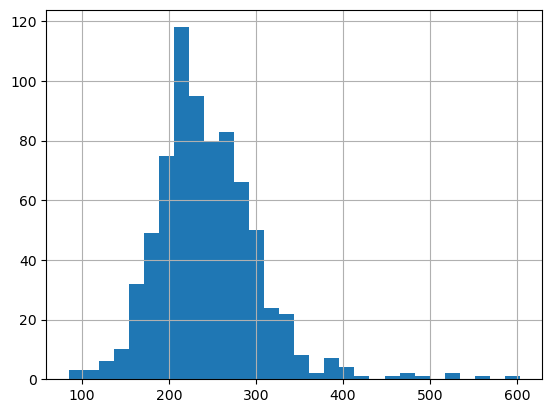

In [25]:
no_zeros = df[df['Cholesterol'] != 0]['Cholesterol']
no_zeros.hist(bins=30)
plt.show()

After imputing the missing values we want to maintain a similar skewness, kurtosis and mean to the ones below.

In [16]:
print(no_zeros.skew())
print(no_zeros.kurtosis())
print(no_zeros.mean())

1.238534436848176
4.5285924196059355
244.6353887399464


What we could have done was to replace all the zeros with the mean of the values (199), but instead we're going to try to calculate a reasonable value for each patients cholesterol. 

To calculate this we choose Age, Max Heart Rate and Resting Blood Pressure to avoid overfitting the imputations.  

In [17]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Select relevant columns
cols_to_use = ['Age', 'MaxHR', 'RestingBP', 'Cholesterol']
df_subset = df[cols_to_use]

In [18]:
df_subset

,Age,MaxHR,RestingBP,Cholesterol
0,40,172,140,289
1,49,156,160,180
2,37,98,130,283
3,48,108,138,214
4,54,122,150,195
...,...,...,...,...
913,45,132,110,264
914,68,141,144,193
915,57,115,130,131
916,57,174,130,236


In [19]:
# Initialize imputer
from sklearn.ensemble import RandomForestRegressor

imputer = IterativeImputer(estimator=RandomForestRegressor(), max_iter=15, random_state=42)

In [20]:
# Change zeros in Cholesterol to null
df_subset.loc[df_subset['Cholesterol'] == 0, 'Cholesterol'] = np.nan

In [21]:
# Perform imputation
imputer.fit(df_subset)

/Users/haraldnilsen/anaconda3/envs/dat158/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


IterativeImputer(estimator=RandomForestRegressor(), max_iter=15,
                 random_state=42)

In [22]:
df_imputed = pd.DataFrame(imputer.transform(df_subset), columns=cols_to_use)

In [23]:
print(df_imputed['Cholesterol'].skew())
print(df_imputed['Cholesterol'].kurtosis())
print(df_imputed['Cholesterol'].mean())

1.2674512099532167
5.093508441954199
245.62300829961615


All of the values have stayed within the same range as before

<Axes: >

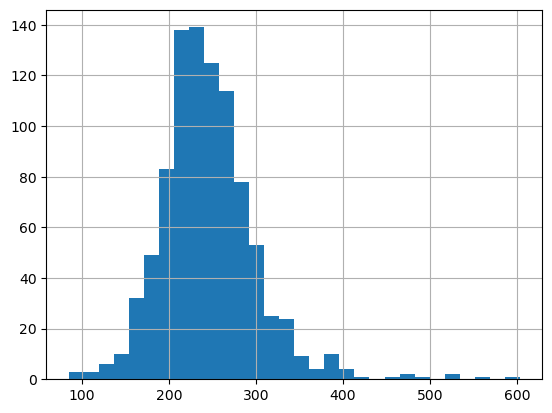

In [24]:
df_imputed['Cholesterol'].hist(bins=30)

/Users/haraldnilsen/anaconda3/envs/dat158/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


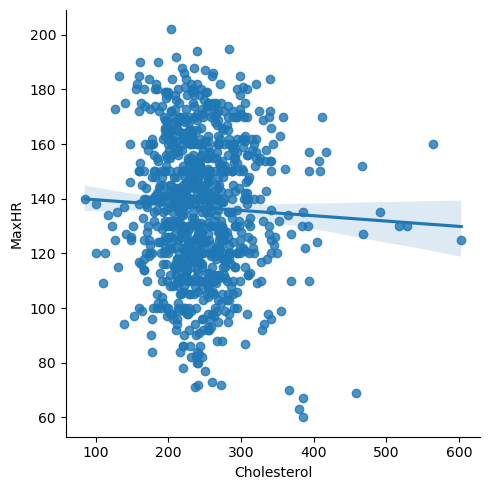

In [26]:
sns.lmplot(x='Cholesterol', y='MaxHR', data=df_imputed)
plt.show()

In [27]:
df['Cholesterol'] = df_imputed['Cholesterol']

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                918 non-null    int64  
 1   Sex                918 non-null    int64  
 2   RestingBP          918 non-null    int64  
 3   Cholesterol        918 non-null    float64
 4   FastingBS          918 non-null    int64  
 5   MaxHR              918 non-null    int64  
 6   Oldpeak            918 non-null    float64
 7   HeartDisease       918 non-null    int64  
 8   ChestPainType_ASY  918 non-null    int64  
 9   ChestPainType_ATA  918 non-null    int64  
 10  ChestPainType_NAP  918 non-null    int64  
 11  ChestPainType_TA   918 non-null    int64  
 12  RestingECG_LVH     918 non-null    int64  
 13  RestingECG_Normal  918 non-null    int64  
 14  RestingECG_ST      918 non-null    int64  
 15  ExerciseAngina_N   918 non-null    int64  
 16  ExerciseAngina_Y   918 non

### 4. Model Selection